In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing import image
from imageio import imsave
import argparse
from utils.dataset_processing.image import DepthImage
import skimage
import skimage.io as io
from skimage.color import rgb2hsv
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, concatenate, Lambda
from keras.layers.core import Dense, Dropout
from keras.models import Model
from keras.callbacks import LambdaCallback
from keras.optimizers import SGD, Adam
import matplotlib.patches as patches
import math
from keras.models import load_model

%matplotlib inline
data_dir = "E:\\專題\\DataSet"

Using TensorFlow backend.


## Read rectangle Files

In [2]:
def read_rect_txt(folder, source):
    lines = []
    f = glob.glob(os.path.join(folder, source, '*cposR.txt'))
    f.sort()
    for files in f:
        file = open(files, 'rt')
        line = file.readlines()
        t = []
        for l in line:
            t.append(list(map(float, l.split())))
        lines.append(t)
    return lines
rect_train = read_rect_txt(data_dir, 'Train')
#rect_validation = read_rect_txt(data_dir, 'Validation')
rect_test = read_rect_txt(data_dir, 'Test')

In [3]:
len(rect_train), len(rect_test)

(834, 35)

In [4]:
rect_train[0]

[[58.0, 175.0], [62.0, 130.0], [155.0, 184.0], [158.0, 139.0]]

In [5]:
#change to (x, y, w, h, theta)
def change_coord_to_box(ld, lu, rd, ru):
    lux, luy = lu[0], lu[1]
    rux, ruy = ru[0], ru[1]
    rdx, rdy = rd[0], rd[1]
    ldx, ldy = ld[0], ld[1]
    x, y = (lux + rdx) / 2, (luy + rdy) / 2
    w, h = math.sqrt((lux - rux)**2 + (luy  - ruy)**2), math.sqrt((rux - rdx)**2 + (ruy - rdy)**2)
    if rux - lux == 0:
        if luy < ruy:
            theta = 90
        else :
            theta = 270
    else:
        theta = math.degrees(math.atan((ruy - luy) / (rux - lux)))
    if theta < 0:
        theta += 360
    return x, y, w, h, theta

In [6]:
def change_rect_to_y(rectss):
    y = []
    for rects in rectss:
        y.append(list(change_coord_to_box(rects[0], rects[1], rects[2], rects[3])))
    return np.array(y)
y_train = change_rect_to_y(rect_train)
#y_validation = change_rect_to_y(rect_validation)
y_test = change_rect_to_y(rect_test)

In [7]:
y_train.shape, y_test.shape

((834, 5), (35, 5))

## Read image files

In [8]:
def load_rgbimages_from_folder(folder, source):
    images = []
    oimg = []
    imgs = glob.glob(os.path.join(folder, source, '*f.png'))
    imgs.sort()
    for filename in imgs:
        img = image.load_img(filename, target_size=(224, 224))
        x = image.img_to_array(img) / 255
        imgo = np.array(Image.open(filename))
        oimg.append(imgo)
        images.append(x)
    return oimg, images

ori_img_train, images_rgb_train = load_rgbimages_from_folder(data_dir, 'Train')
#ori_img_validation, images_rgb_validation = load_rgbimages_from_folder(data_dir, 'Validation')
ori_img_test, images_rgb_test = load_rgbimages_from_folder(data_dir, 'Test')

In [9]:
len(ori_img_train), len(ori_img_test), len(images_rgb_train), len(images_rgb_test)

(834, 35, 834, 35)

In [10]:
hsv_img_train = []
for i in range(len(images_rgb_train)):
    hsv_img_train.append(rgb2hsv(images_rgb_train[i]) * 255)
hsv_img_test = []
for i in range(len(images_rgb_test)):
    hsv_img_test.append(rgb2hsv(images_rgb_test[i]) * 255)

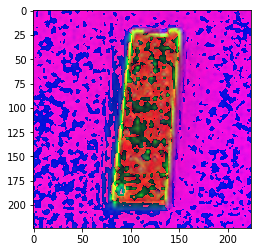

In [11]:
plt.imshow(hsv_img_train[0].astype(np.uint8))

In [12]:
def load_depthimages_from_folder(folder, source):
    images = []
    imgs = glob.glob(os.path.join(folder, source, '*dc.png'))
    imgs.sort()
    for filename in imgs:
        im = image.load_img(filename, target_size=(224, 224))
        im = image.img_to_array(im)
        images.append(im)
    return images

images_depth_train = load_depthimages_from_folder(data_dir, 'Train')
#images_depth_validation = load_depthimages_from_folder(data_dir, 'Validation')
images_depth_test = load_depthimages_from_folder(data_dir, 'Test')

In [13]:
len(images_depth_train), len(images_depth_test), images_depth_train[0].shape

(834, 35, (224, 224, 3))

## Image Preprocessing

## First Training

In [15]:
#inputs
rgb_input = Input(shape = (224, 224, 3), name='rgb_input')
d_input = Input(shape = (224, 224, 3), name='d_input')

resnet = ResNet50(weights='imagenet')
#layers
resnet_rgb = Model(inputs = resnet.input, outputs = resnet.get_layer('avg_pool').output, name = 'ResNet50-RGB')
resnet_d = Model(inputs = resnet.input, outputs = resnet.get_layer('avg_pool').output, name = 'ResNet50-D')
#resnet.summary()

rx = resnet_rgb(rgb_input)
ry = resnet_d(d_input)

#L2_rgb = Lambda(lambda  x: tf.keras.backend.l2_normalize(x,axis=1), name = 'L2_Norm_RGB')(rx)
#L2_d = Lambda(lambda  x: tf.keras.backend.l2_normalize(x,axis=1), name = 'L2_Norm_Depth')(ry)
merge = concatenate([rx, ry])


x = Dense(1024, activation='relu', kernel_initializer='glorot_normal')(merge)
#x = Dropout(0.2)(x)
x = Dense(512, activation='relu', kernel_initializer='glorot_normal')(x)
#x = Dropout(0.2)(x)
x = Dense(256, activation='relu', kernel_initializer='glorot_normal')(x)
#x = Dropout(0.2)(x)
output = Dense(5, activation='relu', kernel_initializer='glorot_normal', name='output')(x)
model_all = Model(inputs = [rgb_input, d_input], outputs = output, name = 'GraspDetection_all')

#ResNet is not trained during first
#model_all.layers[1].trainable = False
#model_all.layers[3].trainable = False
#print(model_all.get_layer('dense_1').get_weights())
model_all.summary()

Model: "GraspDetection_all"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rgb_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
d_input (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
ResNet50-RGB (Model)            (None, 2048)         23587712    rgb_input[0][0]                  
__________________________________________________________________________________________________
ResNet50-D (Model)              (None, 2048)         23587712    d_input[0][0]                    
_________________________________________________________________________________

In [16]:
model_all.compile(optimizer = Adam(lr = 0.001, decay = 1e-6), loss = 'mean_squared_error', metrics = ['acc'])

In [18]:
model_all.fit([images_rgb_train, images_depth_train], y_train, batch_size = 10, epochs = 50, validation_data = ([images_rgb_test, images_depth_test], y_test), verbose = 1)

Train on 834 samples, validate on 35 samples
Epoch 1/50
834/834 [==============================] - 68s 81ms/step - loss: 10846.8580 - acc: 0.3717 - val_loss: 11752.3348 - val_acc: 0.1429
Epoch 2/50
834/834 [==============================] - 63s 75ms/step - loss: 10150.6532 - acc: 0.3885 - val_loss: 12318.7165 - val_acc: 0.1714
Epoch 3/50
834/834 [==============================] - 63s 75ms/step - loss: 10068.7486 - acc: 0.4329 - val_loss: 14298.1599 - val_acc: 0.1714
Epoch 4/50
834/834 [==============================] - 63s 75ms/step - loss: 9819.4624 - acc: 0.4221 - val_loss: 11028.5897 - val_acc: 0.1714
Epoch 5/50
834/834 [==============================] - 66s 79ms/step - loss: 9436.5102 - acc: 0.4592 - val_loss: 13137.9685 - val_acc: 0.1714
Epoch 6/50
834/834 [==============================] - 64s 77ms/step - loss: 9434.7563 - acc: 0.4616 - val_loss: 41178.7455 - val_acc: 0.1714
Epoch 7/50
834/834 [==============================] - 64s 77ms/step - loss: 9201.7792 - acc: 0.4844 - val_

In [32]:
h = model_all.predict(train_img)

In [33]:
for i in range(len(h)):
    print(h[i], y_train[i])

[105.542755  162.13881   106.283325   43.11328     3.6575434] [108.5        157.          96.42095208  45.09988914   5.35582504]
[164.10384   117.238144   56.115276   84.18904     4.0823536] [171.         119.          59.07622195  89.14033879   2.91083783]
[121.43751   153.85593    79.503525   44.09798     1.5452845] [127.         158.5         69.0651866   46.01086828   2.48955292]
[160.68115   123.787      54.6051     86.54158     6.9988446] [167.5        128.          55.22680509  91.35097153   5.19442891]
[141.13356   61.00346   88.874374  43.484283  11.486833] [140.          68.          84.52810184  50.80354318  10.91112838]
[ 96.379974 104.595764  17.330107  14.647068  14.249339] [ 97.5        108.5         19.6468827   16.4924225   14.74356284]
[ 67.65863   85.98373   50.831657  37.24661  347.93173 ] [ 73.          85.          46.5295605   47.38143096 351.34745821]
[104.93356   75.558624  52.057507  37.30355   23.049084] [106.          77.5         53.85164807  44.01136217  2

[119.992874 113.600975 119.41603   60.891525 351.21884 ] [119.         114.5        106.92053124  59.53990259 352.47617956]
[110.28861  109.40389  131.75494   52.145676 343.41623 ] [116.         117.5        126.2893503   55.73149917 351.80573667]
[ 97.988655 111.36126  111.64485   36.54405   23.519672] [ 99.         107.5        104.40306509  39.          20.17065341]
[112.25865  120.70445  115.364044  48.570316 347.03622 ] [118.5        120.5        105.99056562  55.78530272 346.35708522]
[116.393524 113.93584   79.380844  36.298695 309.27145 ] [120.5        116.5         82.61961026  44.04543109 321.88172363]
[106.16901   79.28847  150.69073   40.548954  42.73734 ] [116.5         83.         140.18559127  47.50789408  42.1087304 ]
[127.45636   106.3412     44.53158    80.4975     11.5044565] [127.         110.5         42.95346319  82.          12.09475708]
[ 84.33812  100.92231   94.62665   35.410122 314.4345  ] [ 92.         100.5         94.11163584  43.8634244  312.84703721]
[ 9

D:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


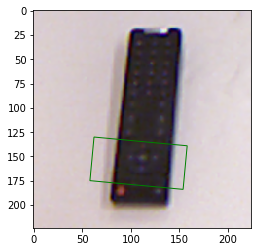

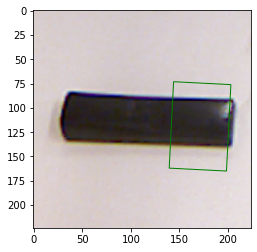

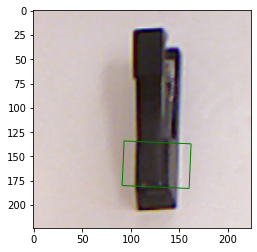

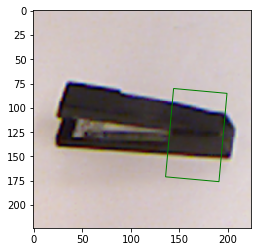

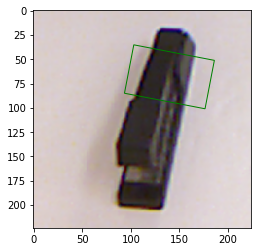

Error in callback <function flush_figures at 0x000002114A8ACAF8> (for post_execute):


KeyboardInterrupt: 

In [52]:
for i in range(len(h)):
    img = ori_img_train[i]
    z = image.img_to_array(img) 
    fig,ax = plt.subplots(1)
    ax.imshow(z.astype(np.uint8))
    rect = patches.Rectangle((h[i][0] - h[i][2]/2, h[i][1] - h[i][3]/2 ),h[i][2],h[i][3],angle = h[i][4],linewidth=1,edgecolor='r',facecolor='none')
    #ax.add_patch(rect)
    rect1 = patches.Rectangle((y_train[i][0] - y_train[i][2], y_train[i][1] - y_train[i][3]),y_train[i][2],y_train[i][3],angle = y_train[i][4],linewidth=1,edgecolor='b',facecolor='none')
    #ax.add_patch(rect1)
    rect2 = patches.Rectangle((rect_train[i][1][0], rect_train[i][1][1]),y_train[i][2],y_train[i][3],angle = y_train[i][4],linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(rect2)

In [35]:
tt = model_all.predict(test_img)

D:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


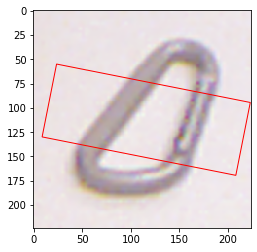

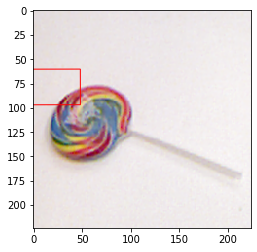

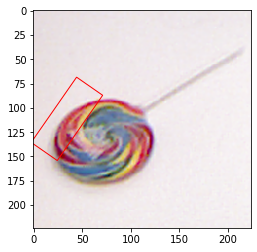

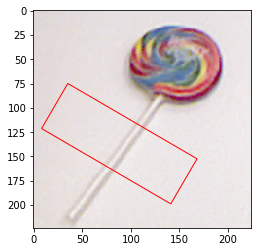

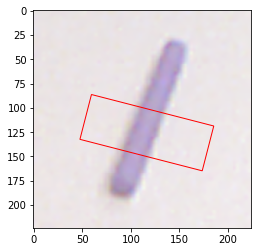

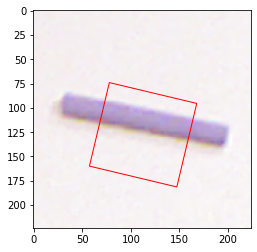

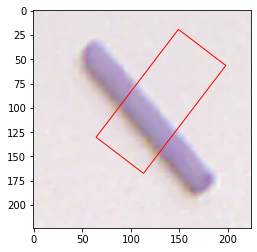

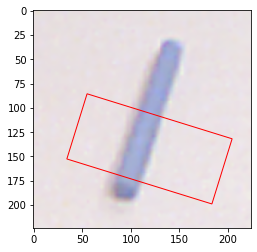

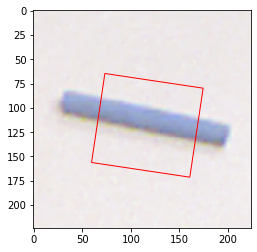

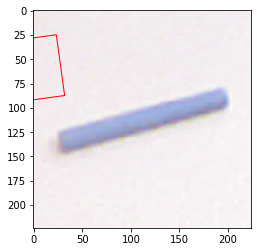

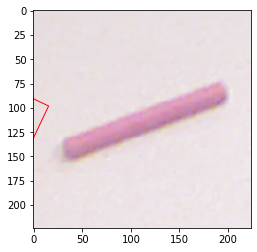

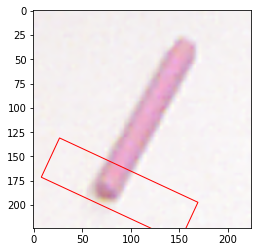

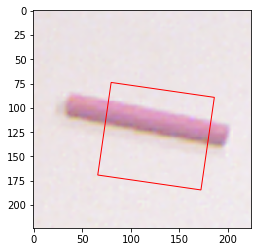

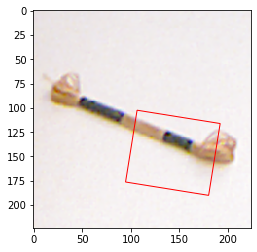

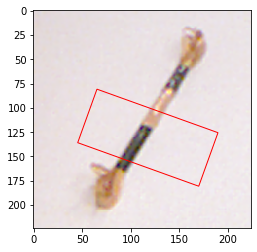

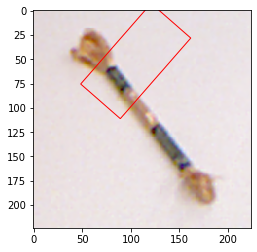

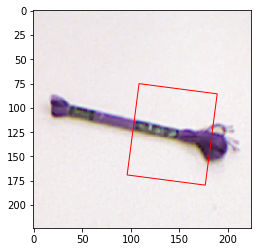

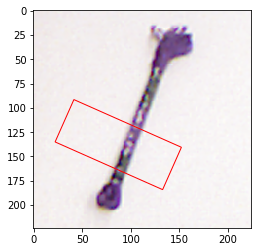

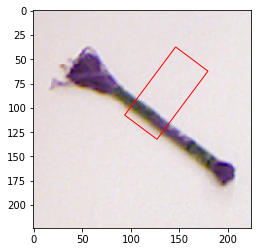

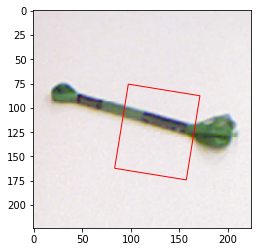

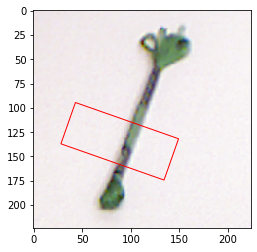

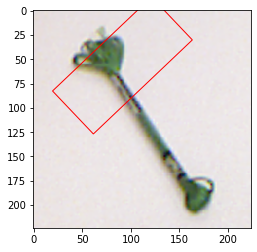

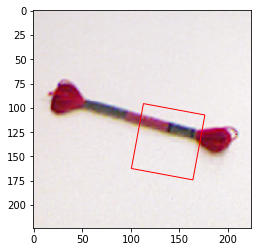

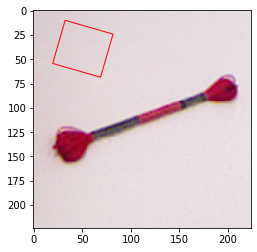

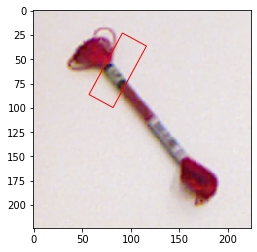

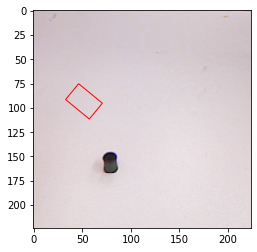

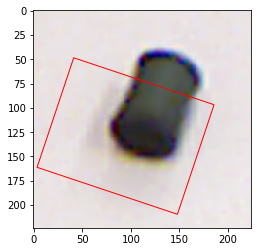

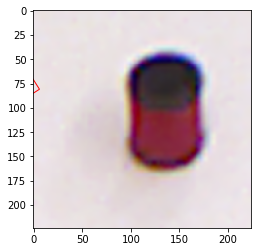

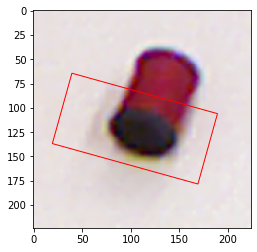

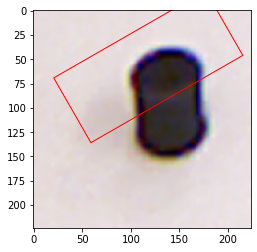

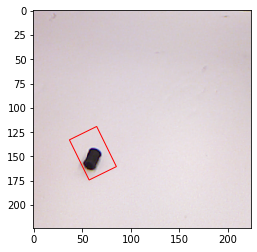

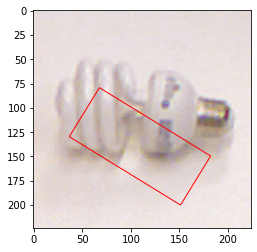

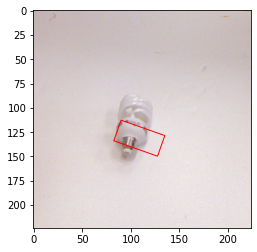

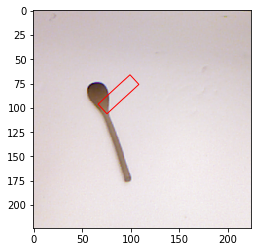

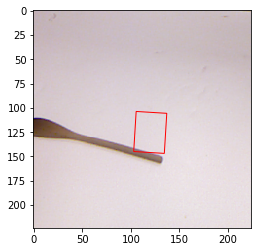

In [36]:
for i in range(len(tt)):
    img = ori_img_test[i]
    z = image.img_to_array(img) 
    fig,ax = plt.subplots(1)
    ax.imshow(z.astype(np.uint8))
    rect = patches.Rectangle((tt[i][0] - tt[i][2] / 2,tt[i][1] - tt[i][3] / 2),tt[i][2],tt[i][3],angle = tt[i][4],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

In [37]:
for i in range(len(tt)):
    print(tt[i], y_test[i])

[125.167755  93.06338  203.43279   76.526596  11.22266 ] [ 98.         137.         212.95304647 115.20850663  13.57945308]
[ 79.653984 115.03157   63.35317   36.687782 179.91962 ] [165.5        152.5         58.18075283  59.16924877  28.76764934]
[111.87186  103.36474   81.87848   32.717022 124.83328 ] [149.          85.          75.60423269  32.80243893  52.52382044]
[112.081375 101.68095  154.07396   53.701065  30.245   ] [ 79.5        158.         115.97413505  60.90155991  29.43848967]
[124.43479  110.037834 130.0829    47.669796  14.434286] [119.          98.         170.88007491 106.28264204  20.55604522]
[124.09386  118.13747   92.558426  88.45473   13.409016] [145.         118.          80.41144197 127.09838709  10.75096699]
[134.06349 160.8756  139.78078  61.41586 307.34894] [124.5        121.         147.82760229  79.32212806 326.30993247]
[133.08325  120.595406 156.43959   70.29468   17.233362] [114.5        117.5        191.00261778 116.37869221  18.62466925]
[124.38812  1

In [28]:
stop

NameError: name 'stop' is not defined

In [38]:
model_all.save('my_model_f.h5')

In [39]:
model = load_model('my_model_f.h5')

In [45]:
im = image.load_img('E:\\專題\\pcd_grasp_img\\rgb_input.png', target_size=(224, 224))
imrgb = image.img_to_array(im)
temp = imrgb / 255

im = image.load_img('E:\\專題\\pcd_grasp_img\\depth_input.png', target_size=(224, 224))
imd = image.img_to_array(im)

hsv_img = []
hsv_img = rgb2hsv(temp) * 255

img = np.empty([1, 224, 224, 3], dtype = float)
img[0, :, :, 0:2] = np.array(hsv_img)[:, :, 0:2]
img[0, :, :, 2] = np.array(imd)[:, :, 1]

In [46]:
test = model.predict(img)

In [47]:
test

array([[134.90584, 154.81989, 174.17319,  55.85154, 306.0565 ]],
      dtype=float32)

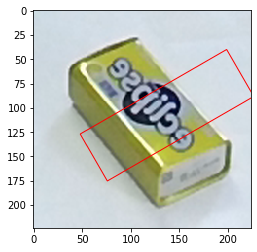

In [51]:
fig,ax = plt.subplots(1)
ax.imshow(imrgb.astype(np.uint8))
rect = patches.Rectangle((test[0][0] - test[0][2]/2, test[0][1] - test[0][3]/2),test[0][2],test[0][3],angle = 330,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

In [44]:
test[0][0] - test[0][2]/2, test[0][1] - test[0][3]/2

(52.40106201171875, 140.58212280273438)